<center style="font-size: 16px; font-weight: normal">
  `21 Microservices Architecture Patterns Study</center>

<center><h1>Chapter 2. Repository Pattern</h1></center>

<center>
  Joseph Kim &lt;cloudeyes@gmail.com&gt;<br/>
  Dec 23. 2020<br/>
</center>

<center>
  <img src="https://images-na.ssl-images-amazon.com/images/I/51-q9CWNBHL._SX379_BO1,204,203,200_.jpg" style="width: 200px">
</center>

<center>
  <a href="https://github.com/cloudeyes/2021-msa-study/blob/main/02-repository-pattern/02-repository-pattern.ipynb">Download Jupyter Notebook</a>
</center>




## Prerequisites

### The folder structure

In [1]:
!tree -I '__pycache__|build|images|plantuml*|exports'

.
├── 02-repository-pattern.ipynb
├── app
│   ├── __init__.py
│   ├── models.py
│   ├── services.py
│   └── tests
│       ├── __init__.py
│       └── test_models.py
└── requirements.txt

2 directories, 7 files


### Install requirements 

In [2]:
!cat ./requirements.txt

sqlalchemy
pytest
git+https://github.com/AllanDaemon/mypy.git@0edf1233672117c4555759c5a91461a502ddce5d


In [3]:
!pip install -r ./requirements.txt

  Cloning https://github.com/AllanDaemon/mypy.git (to revision 0edf1233672117c4555759c5a91461a502ddce5d) to /tmp/pip-req-build-hwbyk86i
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


### Tests

In [4]:
!pytest

============================= test session starts ==============================
platform linux -- Python 3.9.1, pytest-6.1.2, py-1.9.0, pluggy-0.13.1
rootdir: /home/ykkim/notebooks/2021-msa-study/02-repository-pattern
collected 12 items                                                             

app/tests/test_models.py ............                                    [100%]

============================== 12 passed in 0.03s ==============================


In [5]:
!mypy --strict -p app

Success: no issues found in 5 source files


## Persisting Our Domain Model

## Reminder: Our Model

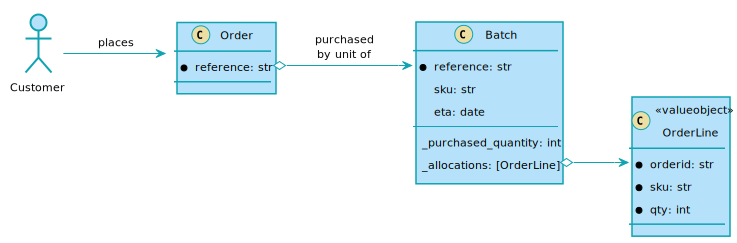

In [6]:
%%plantuml

@startuml

allow_mixing
left to right direction

class Order {
    * reference: str
}

class OrderLine << valueobject >> {
    * orderid: str
    * sku: str
    * qty: int
}

class Batch {
    * reference: str
    sku: str
    eta: date
    --
    _purchased_quantity: int
    _allocations: [OrderLine]
}

actor Customer

Customer --> Order : places
Order::reference o--> Batch::reference : "purchased\nby unit of"
Batch::_allocations o--> OrderLine

@enduml

#### Customers place *orders* for *products*.

- **Product**
  - identified by *SKU*(Stock Keeping Unit)
- **Order**
  - identified by an *order reference* 
  - comprises mutliple *order lines*
- **OrderLine**
  - has a *SKU* and a *quantity*
  
#### The purchasing department orders small *batches* of stock

- **Batch**
  - has a unique ID(*reference*), a *SKU*, and a *quantity* 
  - has an ETA if they are currently shipping
    - or they may be in *warehouse stock*.
  
#### We need to **allocate** *order lines* to *batches*.

- When we allocate x units of stock to a batch, the *available quantity* is reduced by x.

### The "Normal" ORM Way: Model Depends on ORM

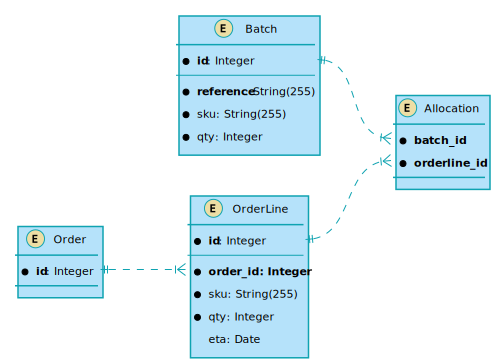

In [7]:
%%plantuml

@startuml

left to right direction

entity Order {
    * **id**: Integer
}

entity Batch {
    * **id**: Integer
    --
    * **reference**: String(255)
    * sku: String(255)
    * qty: Integer
}

entity Allocation {
    * **batch_id**
    * **orderline_id**
}

entity OrderLine {
    * **id**: Integer
    --
    * **order_id: Integer**
    * sku: String(255)
    * qty: Integer
    eta: Date
}


Order::id ||..|{ OrderLine::order_id
OrderLine::id ||..|{ Allocation::orderline_id 
Batch::id ||..|{ Allocation::batch_id 


@enduml

In [8]:
from sqlalchemy import Column, ForeignKey, Integer, String, Date, Table
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship

Base = declarative_base()

class _Order(Base):
    __tablename__ = 'order'
    id = Column(Integer, primary_key=True, autoincrement=True)
    orderlines = relationship('_OrderLine', collection_class=set)
    
class _OrderLine(Base):
    __tablename__ = 'order_line'
    id = Column(Integer, primary_key=True, autoincrement=True)
    sku = Column(String(255))
    qty = Column(Integer)
    orderid = Column(Integer, ForeignKey('order.id'))
    order = relationship(_Order)

allocation = Table('allocation', Base.metadata,
    Column('orderline_id', Integer, ForeignKey('order_line.id'), primary_key=True),
    Column('batch_id', Integer, ForeignKey('batch.id'), primary_key=True)
)
    
class _Batch(Base):
    __tablename__ = 'batch'
    id = Column(Integer, primary_key=True, autoincrement=True)
    reference = Column(String(255), unique=True)
    sku = Column(String(255))
    eta = Column(Date)
    _purchased_quantity = Column(Integer)
    _allocations = relationship(_OrderLine, secondary=allocation, collection_class=set)

In [9]:
def init_engine(url, metadata):
    import io, sys, re, logging
    from sqlalchemy import create_engine
    logger = logging.getLogger("sqlalchemy.engine.base.Engine")
    out = io.StringIO()
    logger.addHandler(logging.StreamHandler(out))
    
    engine = create_engine(url, echo=True) # temporary memory db
    metadata.create_all(engine)
    
    print(''.join(re.findall('CREATE TABLE.*?\n\n', out.getvalue(), re.DOTALL)))
    return engine
    
engine = init_engine('sqlite://', Base.metadata)

CREATE TABLE "order" (
	id INTEGER NOT NULL, 
	PRIMARY KEY (id)
)

CREATE TABLE batch (
	id INTEGER NOT NULL, 
	reference VARCHAR(255), 
	sku VARCHAR(255), 
	eta DATE, 
	_purchased_quantity INTEGER, 
	PRIMARY KEY (id), 
	UNIQUE (reference)
)

CREATE TABLE order_line (
	id INTEGER NOT NULL, 
	sku VARCHAR(255), 
	qty INTEGER, 
	orderid INTEGER, 
	PRIMARY KEY (id), 
	FOREIGN KEY(orderid) REFERENCES "order" (id)
)

CREATE TABLE allocation (
	orderline_id INTEGER NOT NULL, 
	batch_id INTEGER NOT NULL, 
	PRIMARY KEY (orderline_id, batch_id), 
	FOREIGN KEY(orderline_id) REFERENCES order_line (id), 
	FOREIGN KEY(batch_id) REFERENCES batch (id)
)




### Inverting the Dependency: ORM Depends on Model

Using SQLAlchemy's "classical mapping".

In [10]:
from sqlalchemy import MetaData, Table, Column, ForeignKey, Integer, String, Date
from sqlalchemy.orm import mapper, relationship
from app.models import Batch, OrderLine

metadata = MetaData()

order_line = Table(
    'order_line', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('sku', String(255)),
    Column('qty', Integer, nullable=False),
    Column('orderid', String(255)),
    extend_existing=True
)

allocation = Table('allocation', metadata,
    Column('orderline_id', Integer, ForeignKey('order_line.id'), primary_key=True),
    Column('batch_id', Integer, ForeignKey('batch.id'), primary_key=True),
    extend_existing=True
)

batch = Table(
    'batch', metadata,
    Column('id', Integer, primary_key=True, autoincrement=True),
    Column('reference', String(255), unique=True),
    Column('_purchased_quantity', Integer),
    Column('sku', String(255)),
    Column('eta', Date, nullable=True),
    extend_existing=True
)

batch_mapper = mapper(Batch, batch, properties={
    '_allocations': relationship(OrderLine, secondary=allocation, 
                                 collection_class=set, lazy='joined'),
},)

order_line_mapper = mapper(OrderLine, order_line)

In [11]:
from contextlib import contextmanager, AbstractContextManager

from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.orm.session import Session

engine = init_engine('sqlite://', metadata) # temporary memory db

SqliteSessionMaker = sessionmaker(engine, expire_on_commit=False)
SessionFactory = AbstractContextManager[Session]

@contextmanager
def session() -> SessionFactory:
    '''`with session` 블록을 이용한 자동 리소스 반환을 구현합니다.'''
    session = SqliteSessionMaker()
    try:
        yield session
    finally:
        session.close()

CREATE TABLE order_line (
	id INTEGER NOT NULL, 
	sku VARCHAR(255), 
	qty INTEGER NOT NULL, 
	orderid VARCHAR(255), 
	PRIMARY KEY (id)
)

CREATE TABLE batch (
	id INTEGER NOT NULL, 
	reference VARCHAR(255), 
	_purchased_quantity INTEGER, 
	sku VARCHAR(255), 
	eta DATE, 
	PRIMARY KEY (id), 
	UNIQUE (reference)
)

CREATE TABLE allocation (
	orderline_id INTEGER NOT NULL, 
	batch_id INTEGER NOT NULL, 
	PRIMARY KEY (orderline_id, batch_id), 
	FOREIGN KEY(orderline_id) REFERENCES order_line (id), 
	FOREIGN KEY(batch_id) REFERENCES batch (id)
)




In [12]:
from app import mytest

mytest.init(__name__)

@mytest.unit
def test_orderline_mapper_can_load_lines(session):
    with session as db:
        db.execute('''
        INSERT INTO order_line (orderid, sku, qty) VALUES
        ('order1', 'RED-CHAIR', 12),
        ('order2', 'RED-TABLE', 13),
        ('order3', 'BLUE-LIPSTICK', 14)
        ''')
        expected = [
            OrderLine('order1', 'RED-CHAIR', 12),
            OrderLine('order2', 'RED-TABLE', 13),
            OrderLine('order3', 'BLUE-LIPSTICK', 14),
        ]
        assert expected == db.query(OrderLine).all()

✅ test_orderline_mapper_can_load_lines


In [13]:
@mytest.unit
def test_orderline_mapper_can_save_lines(session):
    with session as db:
        new_line = OrderLine('order1', 'DECORATIVE-WIDGET', 12)
        db.add(new_line)
        db.flush()
        
        rows = list(db.execute('SELECT orderid, sku, qty FROM order_line'))
        assert [('order1', 'DECORATIVE-WIDGET', 12)] == rows

✅ test_orderline_mapper_can_save_lines


## Introducing the Repository Pattern

- An abstraction over persistent storage. 
- Hides details of data access by *pretending that all of data is in memory*.

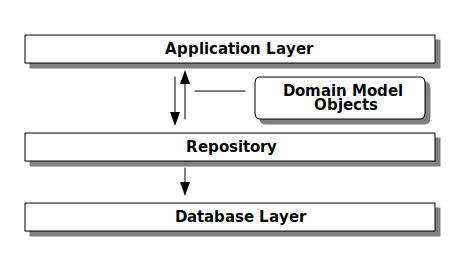

In [14]:
%%ditaa repository-pattern
+----------------------------------------+
|            Application Layer           |
+----------------------------------------+
               |^      /----------------\
               ||------|  Domain Model  |
               ||      |     Objects    |
               V|      \----------------/
+----------------------------------------+
|               Repository               |
+----------------------------------------+
                |
                V
+----------------------------------------+
|              Database Layer            |
+----------------------------------------+        

### The Repository in the Abstract

In [15]:
from typing import Protocol, Iterable, Set
import abc

class AbstractRepository(abc.ABC):

    @abc.abstractmethod
    def add(self, batch: Batch):
        raise NotImplementedError

    @abc.abstractmethod
    def get(self, reference) -> Batch:
        raise NotImplementedError
    
    @abc.abstractmethod
    def list(self) -> list[Batch]:
        raise NotImplementedError     
        
    @abc.abstractmethod
    def clear(self) -> None:
        raise NotImplementedError

# Alternative approache: using `Protocol`
class RepositoryProtocol(Protocol):
    
    def add(self, batch: Batch) -> None:
        pass

    def get(self, reference) -> Batch:
        pass
    
    def list(self) -> list[Batch]:
        pass
    
    def clear(self) -> None:
        pass

### What is the Trade-Off?

Introducing an extra layer of abstraction, 
- Will reduce complexity overall
- But add complexity locally

#### Concrete repository : `SqlAlchemyRepository`

In [16]:
from typing import Optional, Callable

class SqlAlchemyRepository(AbstractRepository):
    
    def __init__(self, session: Callable[[], SessionFactory]):
        self.session = session
    
    def add(self, batch: Batch):
        with self.session() as db:
            db.add(batch)
            db.commit()

    def get(self, reference) -> Optional[Batch]:
        with self.session() as db:
            return db.query(Batch).filter_by(reference=reference).first()
    
    def list(self):
        with self.session() as db:
            return db.query(model.Batch).all()    
    
    def clear(self):
        with self.session() as db:
            db.execute('DELETE FROM allocation')
            db.execute('DELETE FROM batch')
            db.execute('DELETE FROM order_line')
            db.commit()
        
# Repostory fixture
def repo() -> AbstractRepository:
    return SqlAlchemyRepository(session)            

#### Repository test for saving an object

In [17]:
@mytest.unit
def test_repository_can_save_a_batch(repo, session):
    try:
        batch = Batch("batch1", "RUSTY-SOAPDISH", 100, eta=None)
        repo.add(batch)
        with session as db:
            rows = list(db.execute(
                'SELECT reference, sku, _purchased_quantity, eta FROM "batch"'
            ))
            assert rows == [("batch1", "RUSTY-SOAPDISH", 100, None)]
    finally:
        repo.clear()

✅ test_repository_can_save_a_batch


#### Repository test for retrieving a complex object 

In [18]:
def insert_order_line(db, orderid="order1", sku="GENERIC-SOFA"):
    db.execute(
        'INSERT INTO order_line (orderid, sku, qty) '
        'VALUES (:orderid, :sku, 12)',
        dict(orderid="order1", sku="GENERIC-SOFA")
    )
    [orderline_id], *_ = db.execute(
        'SELECT id FROM order_line WHERE orderid=:orderid AND sku=:sku',
        dict(orderid="order1", sku="GENERIC-SOFA")
    )
    return orderline_id


def insert_batch(db, reference, sku="GENERIC-SOFA", qty=100):
    db.execute(
        'INSERT INTO batch (reference, sku, _purchased_quantity) '
        'VALUES (:reference, :sku, :qty)',
        dict(reference=reference, sku=sku, qty=qty)
    )
    [batch_id], *_ = db.execute(
        'SELECT id FROM batch WHERE reference=:reference',
        dict(reference=reference)
    )
    return batch_id


def insert_allocation(db, orderline_id, batch_id):
    db.execute(
        'INSERT INTO allocation (orderline_id, batch_id) '
        'VALUES (:orderline_id, :batch_id)',
        dict(orderline_id=orderline_id, batch_id=batch_id)
    )

@mytest.unit
def test_repository_can_retrieve_a_batch_with_allocations(repo, session):
    try:
        with session as db:
            orderline_id = insert_order_line(db)
            batch1_id = insert_batch(db, "batch1", qty=100)
            batch2_id = insert_batch(db, "batch2")
            insert_allocation(db, orderline_id, batch1_id)

            retrieved = repo.get("batch1")
            expected = Batch("batch1", sku="GENERIC-SOFA", qty=100, eta=None)

        assert retrieved == expected  # Batch.__eq__ only compares reference
        assert retrieved.sku == expected.sku
        assert retrieved._purchased_quantity == expected._purchased_quantity
        assert retrieved._allocations == {
            OrderLine("order1", "GENERIC-SOFA", 12),
        }
    finally:
        repo.clear()

✅ test_repository_can_retrieve_a_batch_with_allocations


## Building a Fake Repository for Tests is Now Trivial!

In [19]:
class FakeRepository(AbstractRepository):

    def __init__(self, batches):
        self._batches = set(batches)

    def add(self, batch):
        self._batches.add(batch)
        
    def get(self, reference):
        return next(b for b in self._batches if b.reference == reference)

    def list(self):
        return list(self._batches)
    
    def clear(self):
        self._batches = set()

#### Example usage of fake repository 

In [20]:
def fake_repo():
    batch1 = Batch("batch1", sku="TEST-TABLE", qty=100)
    batch2 = Batch("batch2", sku="TEST-CHAIR", qty=50)
    batch3 = Batch("batch3", sku="TEST-CABLE", qty=10)
    return FakeRepository([batch1, batch2, batch3])

def fake_request_params():
    return [
        dict(orderid="order1", sku="TEST-TABLE", qty=10),
        dict(orderid="order2", sku="TEST-TABLE", qty=20),
        dict(orderid="order3", sku="TEST-CHAIR", qty=30),
        dict(orderid="order4", sku="TEST-CABLE", qty=10),
    ]

In [21]:
from app.services import allocate

@mytest.unit
def test_fake_repo(fake_repo, session, fake_request_params):
    with session as db:
        batches = fake_repo.list()
        lines = [
            OrderLine(l['orderid'], l['sku'], l['qty'])
            for l in fake_request_params
        ]
        
        for line in lines:
            allocate(line, batches)
        db.commit()    

✅ test_fake_repo


## What is a Port and What is an Adapter, in Python?

Ports and adapters came out of the OO world
- **port** : an interface between our application and whatever we wish to abstract away
- **adapter** : an implementation behind that interface or abstraction.

Python doesn't have interfaces, so defining a port can be simulated with `abc.ABC` or `Protocol`.

In this chapter,
- port : `AbstractRepository`.
- adapters : `SqlAlchemyRepository` and `FakeRepository`.

## Wrap-Up

- Summerize the costs and benefits of each architectural pattern we introduce. 
- Every single application *DO NOT* need to be built this way
  - Make sure the overall complexity of the repository pattern makes it worth in adding extra layers of indirection.
  - If your app is just a simple CRUD wrapper around a database, then YOU DON'T NEED a domain model or a repository.

####  Repository pattern and persistence ignorance: the trade-offs

<table>
<thead>
<tr style="font-size: 14px"><th>Pros</th><th>Cons</th></tr>
</thead>
<tbody>
<tr>
<td style="width: 50%; vertical-align: top">
  <ul style="font-size: 14px">
    <li>We have a simple interface between persistent storage and our domain model.</li>
    <li>It’s easy to make a fake version of the repository for unit testing, or to swap out different storage solutions, because we’ve fully decoupled the model from infrastructure concerns.</li>
    <li>Writing the domain model before thinking about persistence helps us focus on the business problem at hand. If we ever want to radically change our approach, we can do that in our model, without needing to worry about foreign keys or migrations until later.</li>
    <li>Our database schema is really simple because we have complete control over how we map our objects to tables.</li>
  </ul>
</td>
<td style="width: 50%; vertical-align: top">
  <ul style="font-size: 14px">
  <li>An ORM already buys you some decoupling. Changing foreign keys might be hard, but it should be pretty easy to swap between MySQL and Postgres if you ever need to.</li>
  <li>Maintaining ORM mappings by hand requires extra work and extra code.</li>
  <li>Any extra layer of indirection always increases maintenance costs and adds a "WTF factor" for Python programmers who’ve never seen the Repository pattern before.</li>
  </ul>
</td>
</tbody>
</table>

![](images/apwp_0206.png)

#### Repository Pattern Recap

##### Apply dependency inversion to your ORM

Our domain model should be free of infrastructure concerns, so your ORM should import your model, and not the other way around.

##### The Repository pattern is a simple abstraction around permanent storage

The repository gives you the illusion of a collection of in-memory objects. It makes it easy to create a FakeRepository for testing and to swap fundamental details of your infrastructure without disrupting your core application. See [appendix_csvs] for an example.

In [22]:
!jupyter nbconvert 02-repository-pattern.ipynb --output-dir=./exports --to html \
  --TagRemovePreprocessor.remove_input_tags='{"hidden-input"}' \
  --TagRemovePreprocessor.remove_all_outputs_tags='{"hidden-output"}' \
  --TagRemovePreprocessor.remove_cell_tags='{"hidden"}'

[NbConvertApp] Converting notebook 02-repository-pattern.ipynb to html
[NbConvertApp] Writing 671934 bytes to exports/02-repository-pattern.html
